# Mutual information - Where do we begin?
A great first step is to construct a ranking with a feature utility metric, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent. The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:
    - easy to use and interpret,
    - computationally efficient,
    - theoretically well-founded,
    - resistant to overfitting, and,
    - able to detect any kind of relationship

Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other.

The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target

# Interpreting Mutual Information Scores
The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")

df = pd.read_csv("autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [2]:
""" The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that must have a float dtype is not discrete. Categoricals (object or categorial dtype) can be treated as discrete by giving them a label encoding """
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

""" All discrete features should now have integer dtypes """
discrete_features = X.dtypes == int

In [3]:
""" Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical 
    targets (mutual_info_classif). Our target, price, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe. 
"""
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

curb_weight          0.914072
horsepower           0.886604
length               0.616111
fuel_system          0.460284
drive_wheels         0.332645
symboling            0.234951
compression_ratio    0.107311
fuel_type            0.048120
Name: MI Scores, dtype: float64

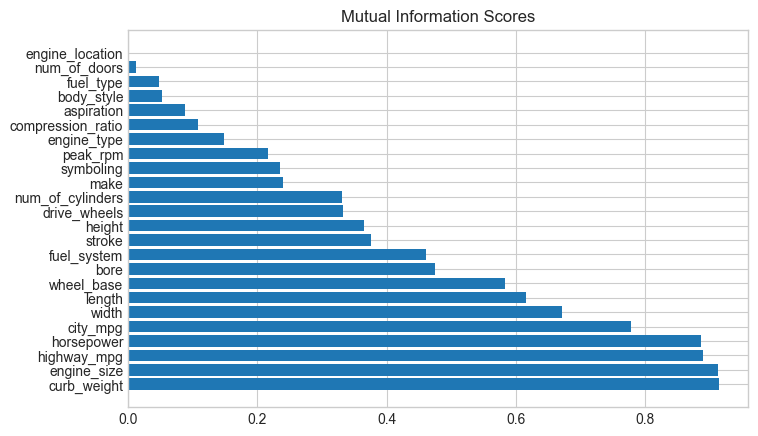

In [4]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=False)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

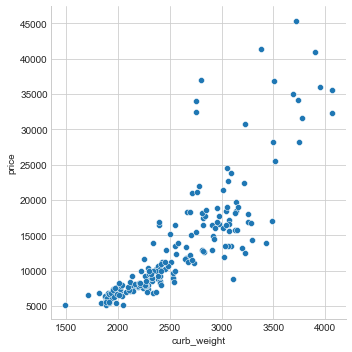

In [5]:
sns.relplot(x="curb_weight", y="price", data=df);

The fuel_type feature has a fairly low MI score, but as we can see from the figure, it clearly separates two price populations with different trends within the horsepower feature. This indicates that fuel_type contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

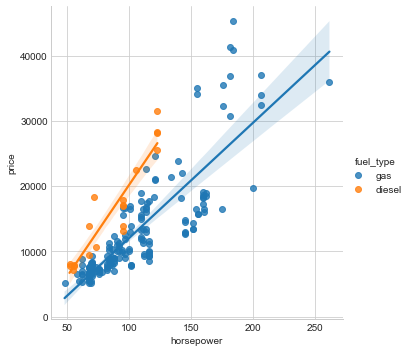

In [6]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

# Creating features - Mathematical Transforms
Relationships among numerical features are often expressed through mathematical formulas, which you'll frequently come across as part of your domain research. In Pandas, you can apply arithmetic operations to columns just as if they were ordinary numbers

# Principal Component Analysis (PCA)
think of PCA as a partitioning of the variation in the data. PCA is a great tool to help you discover important relationships in the data and can also be used to create more informative features.

HOW DO YOU DO A PCA?
    - Standardize the range of continuous initial variables
    - Compute the covariance matrix to identify correlations
    - Compute the eigenvectors and eigenvalues of the covariance matrix to identify the principal components
    - Create a feature vector to decide which principal components to keep
    - Recast the data along the principal components axes

# Target Encoding
A target encoding is any kind of encoding that replaces a feature's categories with some number derived from the target.A simple and effective version is to apply a group aggregation, like the mean. This kind of target encoding is sometimes called a mean encoding. Applied to a binary target, it's also called bin counting

In [ ]:
""" Apenas um exemplo pois não existe essa coluna no dataset """
df["make_encoded"] = df.groupby("make")["price"].transform("mean")

df[["make", "price", "make_encoded"]].head(10)

# Smoothing
An encoding like this presents a couple of problems, however. First are unknown categories. Target encodings create a special risk of overfitting, which means they need to be trained on an independent "encoding" split. When you join the encoding to future splits, Pandas will fill in missing values for any categories not present in the encoding split. These missing values you would have to impute somehow. A solution to these problems is to add smoothing. The idea is to blend the in-category average with the overall average. Rare categories get less weight on their category average, while missing categories just get the overall average.

# Use Cases for Target Encoding
Target encoding is great for:
    - High-cardinality features: A feature with a large number of categories can be troublesome to encode: a one-hot encoding would generate too many features and alternatives, like a label encoding, might not be appropriate for that feature. A target encoding derives numbers for the categories using the feature's most important property: its relationship with the target.

    - Domain-motivated features: From prior experience, you might suspect that a categorical feature should be important even if it scored poorly with a feature metric. A target encoding can help reveal a feature's true informativeness.